In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the DataFrame from CSV
file_path = "../data/prediction/processed_data_all_stations_weather.csv"
df_merged = pd.read_csv(file_path)

# Convert timestamp to datetime if not already
df_merged["timestamp"] = pd.to_datetime(df_merged["timestamp"])

# Extract temporal features
df_merged["hour"] = df_merged["timestamp"].dt.hour
df_merged["day"] = df_merged["timestamp"].dt.day
df_merged["month"] = df_merged["timestamp"].dt.month
df_merged["year"] = df_merged["timestamp"].dt.year
df_merged["day_of_week"] = df_merged["timestamp"].dt.dayofweek  # Monday=0, Sunday=6
df_merged["is_weekend"] = df_merged["day_of_week"].isin([5, 6]).astype(int)  # Boolean to 1/0


# Prepare the feature matrix (X) and target vector (y)
features = ["hour", "day_of_week", "is_weekend", "temperature", "wind_speed", "humidity", "pressure", "rainfall", "available_rent_bikes"]
target = "demand"

# Drop rows with missing values in features or target
df_merged = df_merged.dropna(subset=features + [target])

In [3]:
df_merged.dtypes

youbike_station_id                 int64
timestamp                 datetime64[ns]
available_rent_bikes               int64
available_return_bikes           float64
capacity                         float64
demand                             int64
temperature                      float64
wind_speed                       float64
humidity                         float64
pressure                         float64
rainfall                         float64
hour                               int32
day                                int32
month                              int32
year                               int32
day_of_week                        int32
is_weekend                         int64
dtype: object

In [4]:
df_merged.head()

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand,temperature,wind_speed,humidity,pressure,rainfall,hour,day,month,year,day_of_week,is_weekend
0,500101001,2024-12-24 11:50:00,3,24.0,27.0,-4,16.140000,2.266667,85.642857,1023.65,7.500000,11,24,12,2024,1,0
1,500101001,2024-12-24 12:00:00,7,20.0,27.0,-5,16.166667,2.266667,85.571429,1023.60,7.500000,12,24,12,2024,1,0
2,500101001,2024-12-24 12:10:00,12,15.0,27.0,-3,16.456250,2.250000,85.733333,1023.25,10.666667,12,24,12,2024,1,0
3,500101001,2024-12-24 12:20:00,15,12.0,27.0,3,16.462500,2.312500,85.600000,1023.10,7.625000,12,24,12,2024,1,0
4,500101001,2024-12-24 12:30:00,12,15.0,27.0,4,16.437500,2.312500,86.000000,1023.00,7.656250,12,24,12,2024,1,0


In [5]:
import pandas as pd

# Assuming df_merged has columns: ["timestamp", "youbike_station_id", "demand"]

# Step 1: Group by hour and youbike_station_id to calculate the mean
df_hourly = (
    df_merged
    .set_index("timestamp")
    .groupby([pd.Grouper(freq="1H"), "youbike_station_id"])["demand"]
    .mean()
    .reset_index()
)

# Step 2: Aggregate to get the total demand per hour across all stations
df_hourly_sum = (
    df_hourly
    .groupby("timestamp")["demand"]
    .sum()
    .reset_index()
    .rename(columns={"demand": "hourly_demand_sum"})  # Rename for clarity
)

# Step 3: Calculate the rolling sum of 8-hour intervals
# Use a rolling window to sum over 8 hours
df_hourly_sum["rolling_8h_sum"] = (
    df_hourly_sum["hourly_demand_sum"]
    .rolling(window=8, min_periods=1)  # Allow calculation even for initial rows
    .sum()
)

# Step 4: Identify the interval with the lowest 8-hour rolling sum
min_interval = df_hourly_sum.loc[df_hourly_sum["rolling_8h_sum"].idxmin()]

# Output results
print("Data with Rolling 8-hour Sums:")
print(df_hourly_sum)

print("\nLowest 8-hour Interval:")
print(min_interval)


Data with Rolling 8-hour Sums:
               timestamp  hourly_demand_sum  rolling_8h_sum
0    2024-12-24 11:00:00         111.000000      111.000000
1    2024-12-24 12:00:00         -90.000000       21.000000
2    2024-12-24 13:00:00         -86.583333      -65.583333
3    2024-12-24 14:00:00         -66.916667     -132.500000
4    2024-12-24 15:00:00          13.766667     -118.733333
...                  ...                ...             ...
1200 2025-02-12 11:00:00          57.333333      307.666667
1201 2025-02-12 12:00:00        -137.333333      202.333333
1202 2025-02-12 13:00:00        -171.000000       32.666667
1203 2025-02-12 14:00:00         -85.166667     -201.833333
1204 2025-02-12 15:00:00         -91.333333     -345.333333

[1205 rows x 3 columns]

Lowest 8-hour Interval:
timestamp            2025-01-01 07:00:00
hourly_demand_sum              30.333333
rolling_8h_sum               -856.333333
Name: 188, dtype: object


In [6]:
df_merged.tail()
# let's run it for one station first
sno = 500119096  
df_merged = df_merged[df_merged["youbike_station_id"] == sno]


In [7]:
df_merged.head()

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand,temperature,wind_speed,humidity,pressure,rainfall,hour,day,month,year,day_of_week,is_weekend
10869986,500119096,2024-12-24 12:00:00,14,85.0,99.0,2,16.166667,2.266667,85.571429,1023.60,7.500000,12,24,12,2024,1,0
10869987,500119096,2024-12-24 12:10:00,12,87.0,99.0,2,16.456250,2.250000,85.733333,1023.25,10.666667,12,24,12,2024,1,0
10869988,500119096,2024-12-24 12:20:00,10,89.0,99.0,0,16.462500,2.312500,85.600000,1023.10,7.625000,12,24,12,2024,1,0
10869989,500119096,2024-12-24 12:30:00,10,89.0,99.0,0,16.437500,2.312500,86.000000,1023.00,7.656250,12,24,12,2024,1,0
10869990,500119096,2024-12-24 12:40:00,10,89.0,99.0,1,16.462500,2.312500,85.866667,1022.65,7.687500,12,24,12,2024,1,0


Random Forest Regressor:
MAE: 0.4281
RMSE: 1.1517
R^2 Score: -0.1490

XGBoost Regressor:
MAE: 0.5006
RMSE: 1.3019
R^2 Score: -0.4684


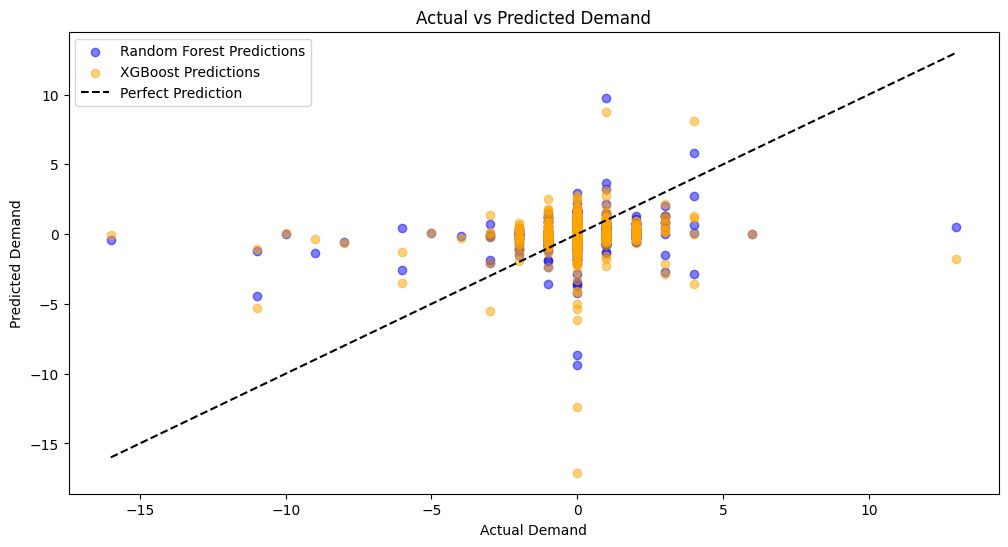

In [9]:
X = df_merged[features]
y = df_merged[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest Regressor:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred_rf):.4f}")

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model
print("\nXGBoost Regressor:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred_xgb):.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest Predictions", color="blue")
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label="XGBoost Predictions", color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.legend()
plt.show()

Random Forest Regressor:
MAE: 0.5855
RMSE: 1.4617
R^2 Score: -0.0417

XGBoost Regressor:
MAE: 0.5480
RMSE: 1.4279
R^2 Score: 0.0058


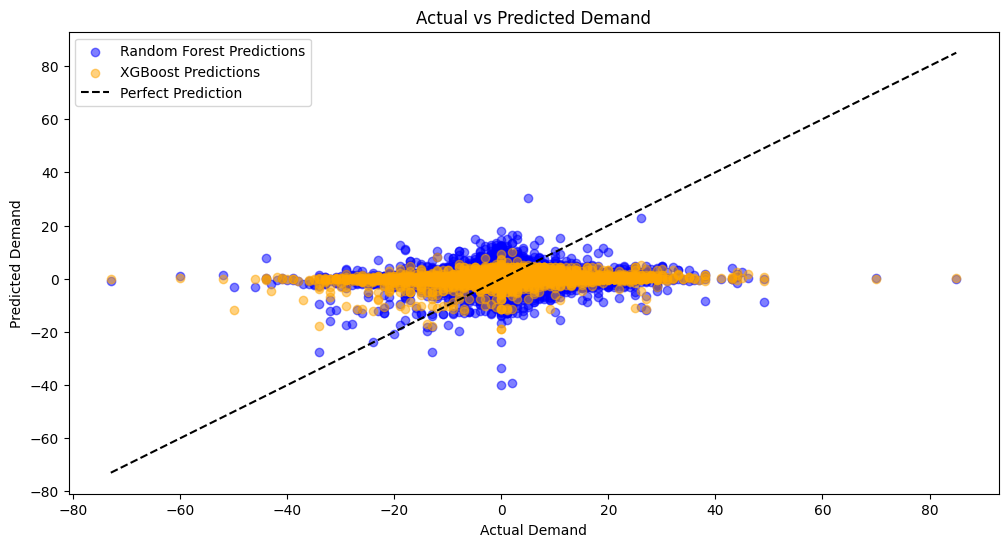

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load the DataFrame from CSV
file_path = "../data/prediction/processed_data_all_stations_weather.csv"
df_merged = pd.read_csv(file_path)

# Convert timestamp to datetime
df_merged["timestamp"] = pd.to_datetime(df_merged["timestamp"])

# Feature engineering 
df_merged["hour"] = df_merged["timestamp"].dt.hour
df_merged["day"] = df_merged["timestamp"].dt.day
df_merged["month"] = df_merged["timestamp"].dt.month
df_merged["year"] = df_merged["timestamp"].dt.year
df_merged["day_of_week"] = df_merged["timestamp"].dt.dayofweek  # Monday=0, Sunday=6

# One-hot encode the day of the week
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
day_of_week_encoded = encoder.fit_transform(df_merged[["day_of_week"]])
day_of_week_columns = [f"day_{i}" for i in range(day_of_week_encoded.shape[1])]
df_encoded = pd.DataFrame(day_of_week_encoded, columns=day_of_week_columns, index=df_merged.index)
df_merged = pd.concat([df_merged, df_encoded], axis=1)

# Sort by timestamp and group by station
df_merged = df_merged.sort_values(by=["youbike_station_id", "timestamp"])

# Shift the demand column to create the target (predict next day's demand)
df_merged["next_day_demand"] = df_merged.groupby("youbike_station_id")["demand"].shift(-144)  # Assuming data is at 10-minute intervals, 144 steps = 1 day

# Drop rows where target (next_day_demand) is NaN
df_merged = df_merged.dropna(subset=["next_day_demand"])

# Prepare feature columns
features = [
    "temperature", "wind_speed", "humidity", "pressure", "rainfall", 
    "available_rent_bikes", "hour", "day", "month", "year"
] + day_of_week_columns
target = "next_day_demand"

# Drop rows with missing values in features
df_merged = df_merged.dropna(subset=features)

# Feature matrix (X) and target vector (y)
X = df_merged[features]
y = df_merged[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest Regressor:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred_rf):.4f}")

# Initialize and train the XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model
print("\nXGBoost Regressor:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred_xgb):.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest Predictions", color="blue")
plt.scatter(y_test, y_pred_xgb, alpha=0.5, label="XGBoost Predictions", color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="black", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Demand")
plt.legend()
plt.show()


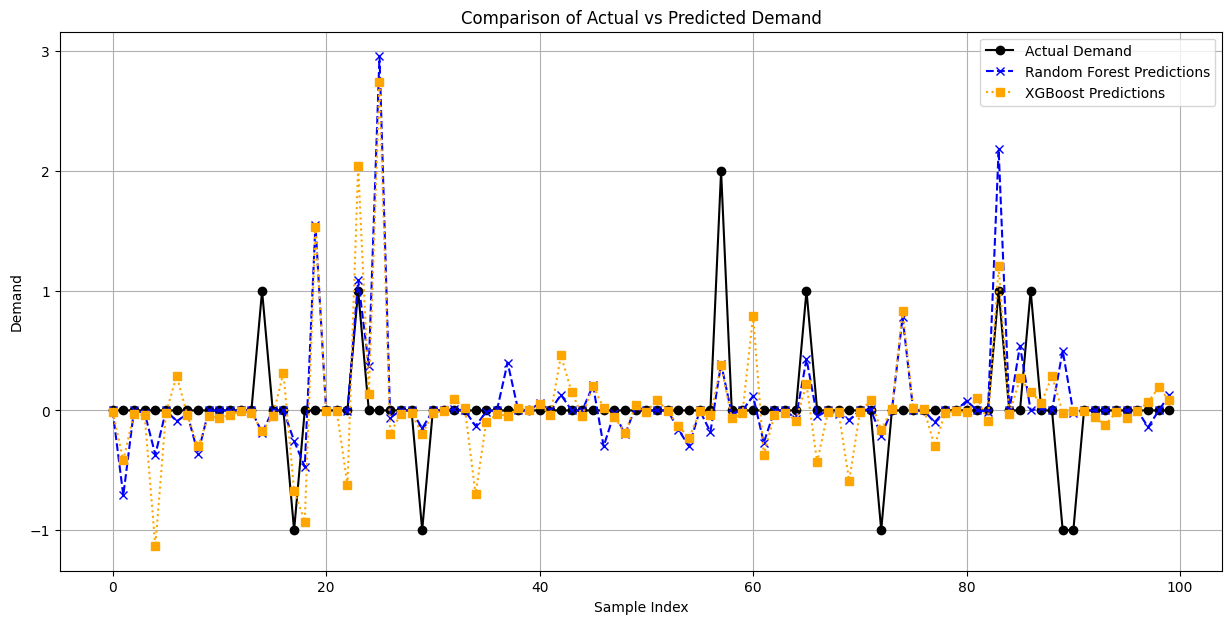

In [10]:
# Select a subset of predictions for visualization (adjust the range as needed)
sample_range = 100  # Number of samples to plot
y_test_sample = y_test[:sample_range]
y_pred_rf_sample = y_pred_rf[:sample_range]
y_pred_xgb_sample = y_pred_xgb[:sample_range]

# Plot the predictions vs actual values
plt.figure(figsize=(15, 7))
plt.plot(y_test_sample.values, label="Actual Demand", color="black", marker="o", linestyle="-")
plt.plot(y_pred_rf_sample, label="Random Forest Predictions", color="blue", marker="x", linestyle="--")
plt.plot(y_pred_xgb_sample, label="XGBoost Predictions", color="orange", marker="s", linestyle=":")

# Add labels, title, and legend
plt.xlabel("Sample Index")
plt.ylabel("Demand")
plt.title("Comparison of Actual vs Predicted Demand")
plt.legend()
plt.grid()
plt.show()

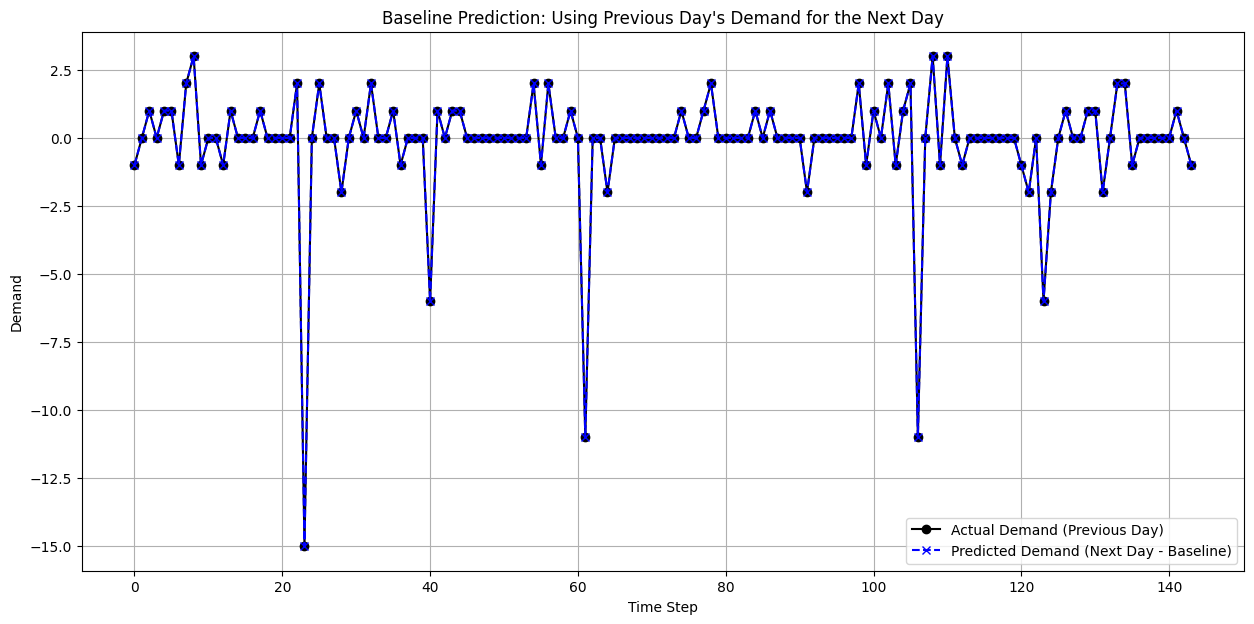

In [24]:
import matplotlib.pyplot as plt

# Define the number of steps in a day based on the data interval (e.g., 144 for 10-minute intervals)
steps_per_day = 144

# Get the last day's actual demand
y_prev_day = y_test[-2*steps_per_day:-steps_per_day]

# Use the previous day as the prediction for the next day
y_pred_next_day_baseline = y_prev_day.values  # Directly replicate the previous day's values

# Create a time index for the next day
time_steps = range(steps_per_day)

# Plot the actual previous day and the "predicted" next day
plt.figure(figsize=(15, 7))

# Plot the actual demand of the previous day
plt.plot(time_steps, y_prev_day.values, label="Actual Demand (Previous Day)", color="black", marker="o", linestyle="-")

# Plot the predicted demand using the previous day's values
plt.plot(time_steps, y_pred_next_day_baseline, label="Predicted Demand (Next Day - Baseline)", color="blue", marker="x", linestyle="--")

# Add labels, title, and legend
plt.xlabel("Time Step")
plt.ylabel("Demand")
plt.title("Baseline Prediction: Using Previous Day's Demand for the Next Day")
plt.legend()
plt.grid()
plt.show()


In [11]:
df_merged

,youbike_station_id,timestamp,available_rent_bikes,available_return_bikes,capacity,demand,temperature,wind_speed,humidity,pressure,...,year,day_of_week,day_0,day_1,day_2,day_3,day_4,day_5,day_6,next_day_demand
0,500101001,2024-12-24 11:50:00,3,24.0,27.0,-4,16.140000,2.266667,85.642857,1023.65,...,2024,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,500101001,2024-12-24 12:00:00,7,20.0,27.0,-5,16.166667,2.266667,85.571429,1023.60,...,2024,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,500101001,2024-12-24 12:10:00,12,15.0,27.0,-3,16.456250,2.250000,85.733333,1023.25,...,2024,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,500101001,2024-12-24 12:20:00,15,12.0,27.0,3,16.462500,2.312500,85.600000,1023.10,...,2024,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-3.0
4,500101001,2024-12-24 12:30:00,12,15.0,27.0,4,16.437500,2.312500,86.000000,1023.00,...,2024,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340955,500119096,2024-12-29 17:10:00,18,81.0,99.0,2,15.831579,2.052632,69.111111,1022.25,...,2024,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
1340956,500119096,2024-12-29 17:20:00,16,83.0,99.0,-1,15.694444,2.111111,70.000000,1022.30,...,2024,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1340957,500119096,2024-12-29 17:30:00,17,82.0,99.0,0,15.773684,2.052632,69.333333,1022.45,...,2024,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1340958,500119096,2024-12-29 17:40:00,17,82.0,99.0,0,15.752632,2.000000,69.444444,1022.50,...,2024,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [14]:
len(df_merged)/len(df_merged['youbike_station_id'].unique())

755.4661301140175